# Introduction

*Saccharomyces cerevisiae* is a yeast, small single-cell eukaryote, known for the fermentation. Obviously, it has been used for winemaking, baking, and brewing since first emerging civilizations. Thanks to its characteristics, *Saccharomyces cerevisiae* is examined as a convenient model organism.
We are going to study its  gene regulatory network using graph theory and python **networkx** library.

# Exploration and characterization of the gene regulatory network

In [1]:
import networkx as ntx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz as pgv
ntx.__version__

'2.3'

The file *GRN_edges_S_cerevisiae.txt* contains the edges between transcription factors and target genes. It will serve us to create our graph. We drop the first colomn which has no further interest.

In [2]:
network = pd.read_csv("GRN_edges_S_cerevisiae.txt", sep = ',', header=0)
gene = pd.read_table("net4_gene_ids.tsv", sep = '\t')
transcription= pd.read_table('net4_transcription_factors.tsv')
mapping = pd.read_table('go_slim_mapping.tab.txt', header = None)

In [3]:
network = network.drop('Unnamed: 0', axis=1)
network.head()

,transcription_factor,target_gene
0,G15,G1
1,G98,G1
2,G109,G1
3,G22,G9
4,G211,G11


In [4]:
gene.head()

,ID,Name
0,G1,YHR084W
1,G2,YER109C
2,G3,YDR496C
3,G4,YBR098W
4,G5,YNL139C


In [5]:
transcription.head()

,transcription_factor
0,G1
1,G2
2,G3
3,G4
4,G5


In [6]:
mapping.head()

,0,1,2,3,4,5,6
0,HRA1,HRA1,S000119380,C,cellular_component,GO:0005575,ncRNA_gene
1,HRA1,HRA1,S000119380,F,molecular_function,GO:0003674,ncRNA_gene
2,HRA1,HRA1,S000119380,P,rRNA processing,GO:0006364,ncRNA_gene
3,HRA1,HRA1,S000119380,P,ribosomal small subunit biogenesis,GO:0042274,ncRNA_gene
4,ICR1,ICR1,S000132612,C,nucleus,GO:0005634,ncRNA_gene


In [7]:
G = ntx.DiGraph()
G = ntx.from_pandas_edgelist(network, 'transcription_factor', 'target_gene', create_using = ntx.DiGraph())
ntx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 1994\nNumber of edges: 3940\nAverage in degree:   1.9759\nAverage out degree:   1.9759'

C:\Computations\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Computations\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


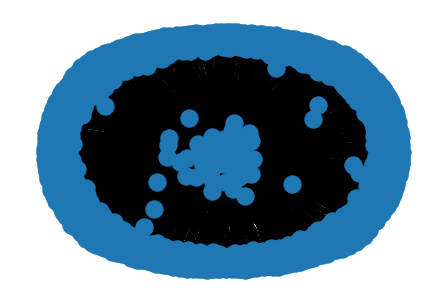

In [8]:
ntx.draw(G)

We draw the network using *draw()* method. This image is not really clear and we gave to find another method in order to get a clear representation of the graph.

In [9]:
both_genes = set(network['transcription_factor']).intersection(network['target_gene'])
regulatory_genes = set(network['transcription_factor']) - set(both_genes)
target_genes = set(network['target_gene']) - set(both_genes)

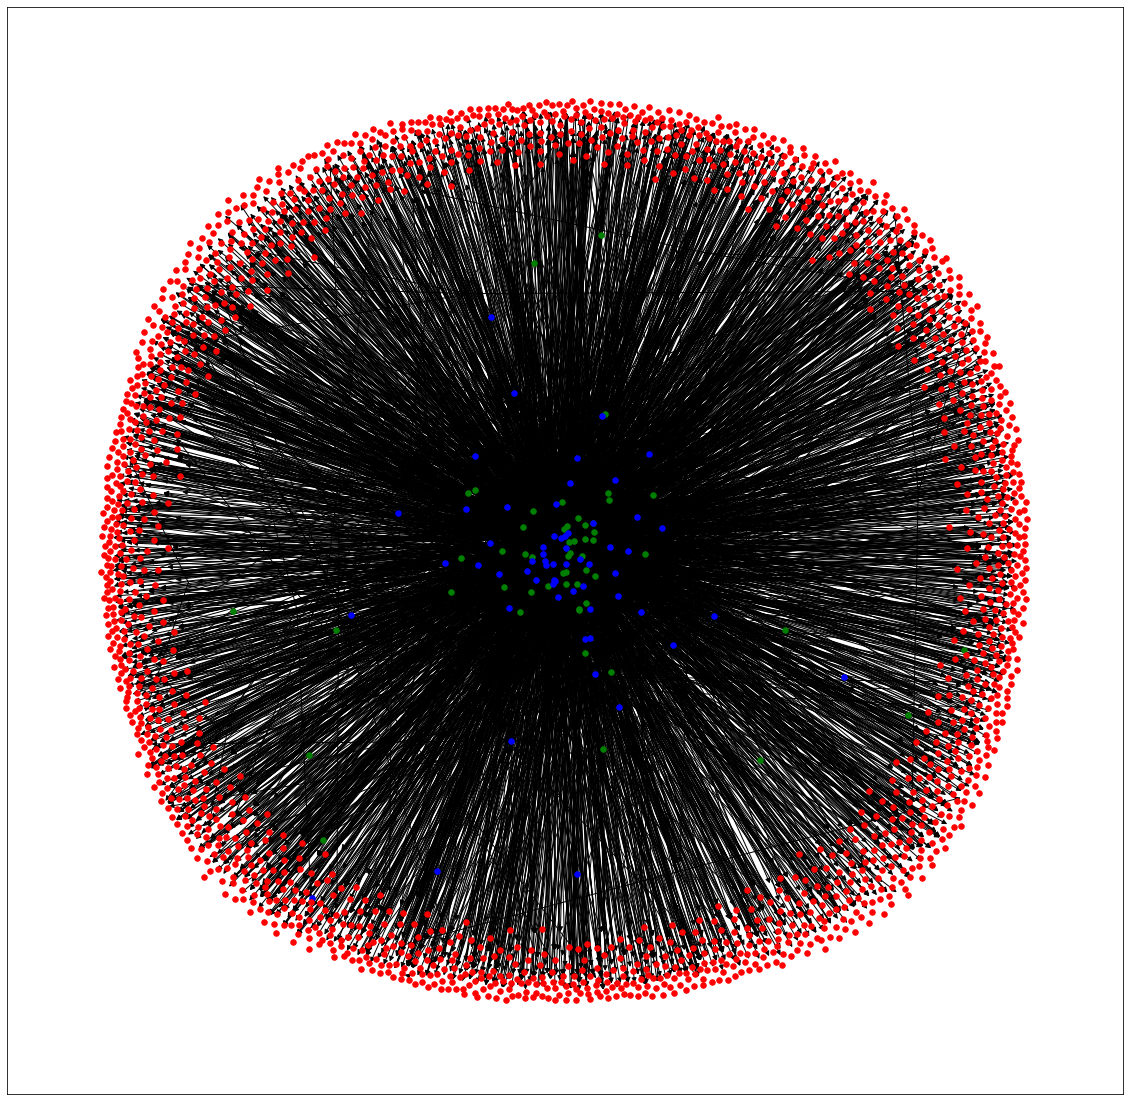

In [10]:
plt.figure(figsize=(20,20))
ntx.draw_networkx_edges(G, pos = ntx.spring_layout(G), edgelist = list(G.edges()))
ntx.draw_networkx_nodes(G, nodelist= list(both_genes), 
                       node_color = 'g',  pos = ntx.spring_layout(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist= list(regulatory_genes), 
                       node_color = 'b',  pos = ntx.spring_layout(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist=list(target_genes) , 
                       node_color = 'r',  pos = ntx.spring_layout(G), with_labels = False, node_size = 30)

Even though this image gives us a better idea about the disposition of factors and genes in the graph, we would like to get a figure that specifies if there are some particular parts in the graph. For that, we'll use the *nx_agraph.graphviz_layout* method. (if it will work some day)

In [11]:
"""
plt.figure(figsize=(20,20))
ntx.draw_networkx_edges(G, pos = ntx.nx_agraph.graphviz_layout(G), edgelist = list(G.edges()))
ntx.draw_networkx_nodes(G, nodelist= list(both_genes), 
                       node_color = 'g',  pos = ntx.nx_agraph.view_pygraphviz(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist= list(regulatory_genes), 
                       node_color = 'b',  pos = ntx.nx_agraph.view_pygraphviz(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist=list(target_genes) , 
                       node_color = 'r',  pos = ntx.nx_agraph.view_pygraphviz(G), with_labels = False, node_size = 30)
                       """

"\nplt.figure(figsize=(20,20))\nntx.draw_networkx_edges(G, pos = ntx.nx_agraph.graphviz_layout(G), edgelist = list(G.edges()))\nntx.draw_networkx_nodes(G, nodelist= list(both_genes), \n                       node_color = 'g',  pos = ntx.nx_agraph.view_pygraphviz(G), with_labels = False, node_size = 30)\nntx.draw_networkx_nodes(G, nodelist= list(regulatory_genes), \n                       node_color = 'b',  pos = ntx.nx_agraph.view_pygraphviz(G), with_labels = False, node_size = 30)\nntx.draw_networkx_nodes(G, nodelist=list(target_genes) , \n                       node_color = 'r',  pos = ntx.nx_agraph.view_pygraphviz(G), with_labels = False, node_size = 30)\n                       "

We will study the network by computing some of its characteristics.

#### Clustering coefficient

In [20]:
ntx.average_clustering(G)

0.04436303023690503

#### Betweeness centrality

In [21]:
ntx.betweenness_centrality(G)

{'G15': 0.002054588986486169,
 'G1': 0.0015213891189444185,
 'G98': 0.00011120749934005968,
 'G109': 7.926000707966503e-05,
 'G22': 9.771062843110189e-05,
 'G9': 0.0,
 'G211': 0.00015062759820012615,
 'G11': 0.00023324608015604814,
 'G41': 0.0008126669581822859,
 'G12': 0.0,
 'G13': 0.0,
 'G68': 0.0004601110580472081,
 'G14': 0.0002925861331259139,
 'G87': 0.0,
 'G111': 0.00034850473981559287,
 'G273': 0.0005013573276212394,
 'G45': 0.0015743060887134421,
 'G112': 0.0005769859837409513,
 'G168': 0.0,
 'G254': 0.0,
 'G76': 0.0,
 'G19': 3.526398620069843e-06,
 'G61': 0.0,
 'G20': 0.0,
 'G224': 0.0,
 'G319': 9.1308535698237e-05,
 'G21': 0.0,
 'G95': 0.0,
 'G101': 0.00031133062102902325,
 'G212': 1.4231537288139008e-05,
 'G138': 0.0,
 'G23': 0.0,
 'G25': 0.0005507059178342403,
 'G27': 0.0,
 'G29': 2.518856157192745e-07,
 'G121': 0.0,
 'G30': 0.0,
 'G139': 0.0,
 'G227': 3.6649357087154436e-05,
 'G37': 0.0,
 'G47': 0.0006562459908206164,
 'G274': 0.0,
 'G298': 0.0006464644327435179,
 'G43': 

#### Degrees in and out

In [13]:
adj_G = ntx.to_numpy_matrix(G, nodelist=G.nodes())
adjacency = pd.DataFrame(adj_G)
in_degree = adjacency.sum(axis=0).sort_values() 
out_degree = adjacency.sum(axis=1).sort_values() 

14.0


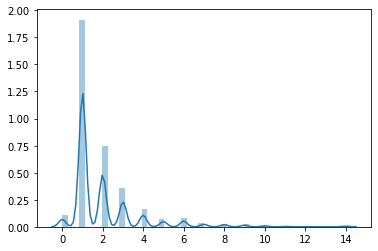

In [14]:
in_dict = {}
for node in G.nodes:
    in_dict[node] = G.in_degree(node)
    
print(max(in_degree))
sns.distplot(in_degree)

217.0


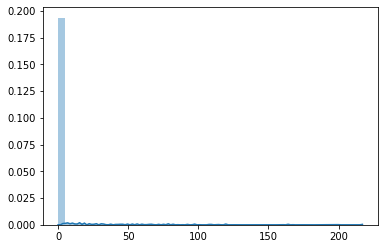

In [15]:
out_dict = {}
for node in G.nodes:
    out_dict[node] = G.out_degree(node)
print(max(out_degree))
sns.distplot(out_degree)


# Community detection

### Girvan–Newman algorithm

L'algorithme de Girvan–Newman est une méthode qui sert à trouver des communautés dans des graphes complexes.
Le but de cette méthode est d'identifier les edges qui se trouvent probablement entre les communauté, de les enlever et donc de récuperer les communautés individuelles.

L'algorhitme procéde de cette manière :
- calculer la *betweennes* de tous les edges du graphe
- enlever les edges ayant la *betweennes* plus élevée
- recalculer la *betweennes* des edges concernés
- refaire les étapes 2 et 3

En effet, les premiers edges à enlever auront la plus grande *betweennes* et donc seront beaucoup utilisés pour effectuer le passage le plus court entre 2 noeuds du graphe. Ce sont alors bien les edges qui servent comme des "ponts" entre les différentes communautés et sont beaucoup parcourus pour passer d'un côté du graphe à l'autre.

In [16]:
import itertools

k = 2
comp = ntx.algorithms.community.centrality.girvan_newman(G)

In [17]:
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    print(tuple(comm for comm in communities)) 

###  Louvain algorithm 

In [18]:
ntx.community.best_partition(G)

AttributeError: module 'networkx.algorithms.community' has no attribute 'best_partition'

# Conclusion